In [1]:
%run init_notebook.py
from settings import *

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import scipy

### Ramsay

In [3]:
params = sp.symbols(['delta', 'alpha', 'rho', 'n', 'x', 'theta', 'sigma', 'A', '\hat{k}(t)', '\hat{c}(t)'])
delta, alpha, rho, n, x, theta, sigma, A, kt, ct= params

yt = A*kt**alpha
ut = ct**(1-theta) / (1-theta)

ctd = 1/sigma * ct * (yt.diff(kt) - (delta + rho + sigma * x)) # set to 0 and obtain k*
ktd = yt - (delta + n + x) * kt - ct # set to zero and obtain c*

kss = sp.solve(ctd, kt)[0]
css = sp.solve(ktd.subs(kt, kss), ct)[0]

cts = sp.solve(ktd, ct)[0]
ct0 = sp.solve(sp.solve(ktd, ct)[0], kt)[0]

kgold = sp.solve(sp.solve(ktd, ct)[0].diff(kt), kt)[0]
cgold = sp.solve(ktd, ct)[0].subs(kt, kgold)

make_cts = sp.lambdify(params, cts)
make_css = sp.lambdify(params, css)
make_kss = sp.lambdify(params, kss)
make_ct0 = sp.lambdify(params, ct0)

make_kgold = sp.lambdify(params, kgold)
make_cgold = sp.lambdify(params, cgold)

In [4]:
def plot_ramsay(params, simulations, color, width=.8, gkw=[4, 1]):

    gkw = dict(width_ratios=gkw)
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw=gkw)
    
    for i in params:
        δ, α, ρ, n_, x_, θ, σ, A_ = i
        ind = params.index(i)
        _ct0 = make_ct0(δ, α, ρ, n_, x_, θ, σ, A_, 0, 0)
        capital = np.linspace(0, _ct0, simulations)
        consum = np.zeros(simulations)
        
        for i in range(0, simulations):
            consum[i] = make_cts(δ, α, ρ, n_, x_, θ, σ, A_, capital[i], 0)

        ax[0].hlines(make_css(δ, α, ρ, n_, x_, θ, σ, A_, 0, 0),
                     0,
                     make_kss(δ, α, ρ, n_, x_, θ, σ, A_, 0, 0),
                     color=color[ind][0], linewidth=width, label='ss')
        ax[0].vlines(make_kss(δ, α, ρ, n_, x_, θ, σ, A_, 0, 0),
                     0,
                     make_css(δ, α, ρ, n_, x_, θ, σ, A_, 0, 0),
                     color=color[ind][0], linewidth=width)

        ax[0].hlines(make_cgold(δ, α, ρ, n_, x_, θ, σ, A_, 0, 0),
                     0,
                     make_kgold(δ, α, ρ, n_, x_, θ, σ, A_, 0, 0), 
                     color=color[ind][1], linestyle='dashed',linewidth=width, label='gold')
        ax[0].vlines(make_kgold(δ, α, ρ, n_, x_, θ, σ, A_, 0, 0),
                     0,
                     make_cgold(δ, α, ρ, n_, x_, θ, σ, A_, 0, 0),
                     color=color[ind][1], linestyle='dashed', linewidth=width)

        ax[0].plot(capital, consum, color=color[ind][2], label='$\hat{c}$')

        ax[0].legend()
        ax[0].set_xlabel('$\dot{\hat{k}}$', size=12)
        ax[0].set_ylabel('$\dot{\hat{c}}$', size=12)
        ax[0].set_title('Phase diagram')
        
        print(f'KSS: {make_kss(δ, α, ρ, n_, x_, θ, σ, A_, 0, 0)}')
        print(f'KGOLD: { make_kgold(δ, α, ρ, n_, x_, θ, σ, A_, 0, 0)}')

    plt.tight_layout();

In [5]:
css

A*(((delta + rho + sigma*x)/(A*alpha))**(1/(alpha - 1)))**alpha - delta*((delta + rho + sigma*x)/(A*alpha))**(1/(alpha - 1)) - n*((delta + rho + sigma*x)/(A*alpha))**(1/(alpha - 1)) - x*((delta + rho + sigma*x)/(A*alpha))**(1/(alpha - 1))

In [6]:
kss

((delta + rho + sigma*x)/(A*alpha))**(1/(alpha - 1))

KSS: 0.09765624999999999
KGOLD: 0.5102040816326531
KSS: 0.08650519031141869
KGOLD: 0.39062499999999994


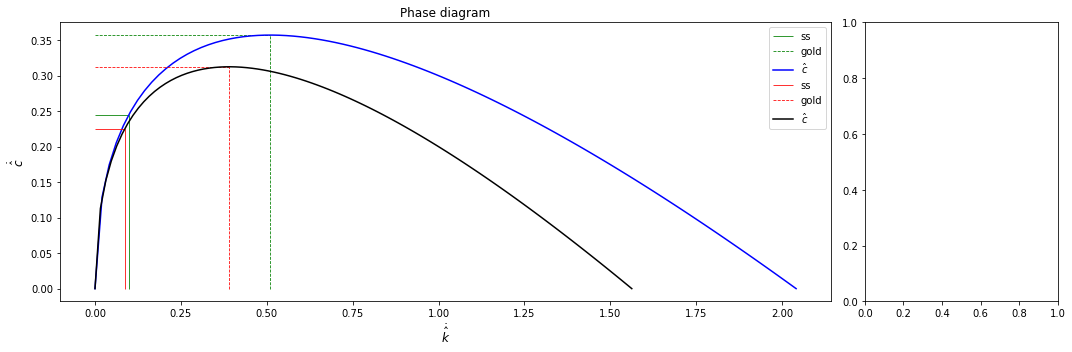

In [11]:
plot_ramsay(
            params=[
#                     [δ, α, ρ, n_, x_, θ, σ=1\θ, A_]
                    [.1, .5, .5, .1, .5, .5, 1/.5, 1],
                    [.2, .5, .5, .1, .5, .5, 1/.5, 1]
                    ],
            color=[['green', 'green', 'blue'], ['red', 'red', 'black']],
            simulations=100
            )

#### Linearisation

In [8]:
params = sp.symbols(['\dot{\hat{k_t}}', '\dot{\hat{c_t}}', '\hat{k_t}', '\hat{c_t}',
                     'rho', 'n', 'theta', 'x', 'alpha', 'delta', 'sigma', 'A'])
ktd, ctd, kt, ct, rho, n, theta, x, alpha, delta, sigma, A = params

In [9]:
yt = A*kt**alpha



ss = sp.Matrix([kss, css]).reshape(1, 2)
xt = sp.Matrix([ktd - kss, ctd - css])
xd = sp.Matrix([kt, ct])

dj = sp.Matrix([[rho - n - (1-theta)*x, -1],
                [ct/theta * yt.diff(kt).diff(kt).subs(kt, kss), 0]])
dj = sp.Matrix([[a, b], [c, d]])

xt_ss = sp.Matrix([kt - kss, ct - css]).reshape(1, 2)

# diff_eq = sp.Eq(xt = xd + jd @ kss)

# make_kss = sp.lambdify(params, kss)
# make_xt = sp.lambdify(params, xt)
# make_xd = sp.lambdify(params, xd)
# make_jd = sp.lambdify(params, jd)
# make_xt_ss = sp.lambdify(params, xt_ss)


NameError: name 'a' is not defined

In [ ]:
kss = 1/sigma * ct * (yt.diff(kt) - (delta + rho + sigma * x))
kss = sp.solve(kss, kt)[0]

css = yt - (delta + n + x) * kt - ct
css = sp.solve(css, ct)[0]
css = css.subs(kt, kss)

d = sp.Matrix([[rho - n - (1 - theta)*x, x + n + delta - (rho + x + delta) / alpha],
              [-(1 - alpha) * (rho + theta * x + delta) / theta, 0]])
xt = sp.Matrix([sp.log(kt / kss), sp.log(ct/css)])
xd = sp.Matrix([sp.log(ktd), sp.log(ctd)])

loglin = sp.Eq(xd, d @ xt)

make_kss = sp.lambdify(params, kss)
make_css = sp.lambdify(params, css)


make_xt = sp.lambdify(params, xt)
make_loglin = sp.lambdify(params, loglin)
make_d = sp.lambdify(params, d)
make_d_eig = sp.lambdify(params, d.eigenvals())

In [ ]:
ρ = 1
n_ = .1
θ = .5
α = .8
x_ = .1
δ = .1
A_ = 1
σ = 1/θ

# 0, 0, 0, 0, ρ, n_, θ, α, x_, δ, A_

kss_ = make_kss(0, 0, 0, 0, ρ, n_, θ, α, x_, δ, σ, A_)
css_ = make_css(0, 0, 0, 0, ρ, n_, θ, α, x_, δ, σ, A_)

simulations = 100
interval = .2

kt_range = np.linspace(kss_ * (1-interval), kss_ * (1+interval), simulations)

In [ ]:
lam_d = scipy.linalg.eigh(make_d(0, 0, 0, 0, ρ, n_, θ, α, x_, δ, σ, A_), eigvals_only=True)
lam_d

In [ ]:
log_ktd = np.zeros(simulations)
log_ctd = np.zeros(simulations)

for i in range(0, simulations):
    xt_ = make_xt(0, 0, kt_range[i], css_, ρ, n_, θ, α, x_, δ, σ, A_)
    d_ = make_d(0, 0, 0, 0, ρ, n_, θ, α, x_, δ, σ, A_)

    xd_ = d_ @ xt_
    
    log_ktd[i] = xd_[0]
    log_ctd[i] = xd_[1]

In [ ]:
css_

In [ ]:
kss_

In [ ]:
plt.plot(sim_range, np.exp(log_ctd))
plt.vlines(kss_, np.exp(log_ctd)[0], np.exp(log_ctd)[-1], color='blue', label='kss')
plt.hlines(css_, sim_range[0], sim_range[-1], color='red', label='css')
plt.legend()

In [ ]:
xt

In [ ]:
css_

In [ ]:
for i in 

In [ ]:
xt_ = make_xt(0, 0, kss_*1.01, css_*1.01, ρ, n_, θ, α, x_, δ, σ, A_)
d_ = make_d(0, 0, kss_*1.01, css_*1.01, ρ, n_, θ, α, x_, δ, σ, A_)

xd_ = d_ @ xt_

In [ ]:
xd_

In [ ]:
make_loglin(0, 0, 0, 0, ρ, n_, θ, α, x_, δ, A_)